In [2]:
####################导入数据
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor ######随机森林
from sklearn.model_selection import train_test_split  #####数据集划分
from sklearn.metrics import mean_absolute_error       ####评价指标MAE(辅助指标)
from sklearn.preprocessing import LabelEncoder       ####编码

from sklearn.linear_model import LinearRegression  #####线性回归
import xgboost as xgb
from sklearn.linear_model import Lasso  ####lasso回归

house_train = pd.read_csv('C:\\Users\\dell\\Desktop\\train_data.csv',encoding = 'gbk') 
house_test = pd.read_csv('C:\\Users\\dell\\Desktop\\test_a.csv',encoding = 'gbk')

C:\Users\dell\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dell\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\dell\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\dell\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.1.0' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
##########################缺失值填充
############缺失值查找
all_data_na = (house_train.isnull().sum()/len(house_train))*100
all_data_na = pd.DataFrame({'缺失值占比':all_data_na})
all_data_na = all_data_na.loc[all_data_na['缺失值占比'] > 0,:] #####找出有缺失值的指标
all_data_na 

,缺失值占比
pv,0.043436
uv,0.043436


结果显示只有pv和uv两个变量有缺失值，并且缺失比例不高，可以用变量均值填充缺失值：

In [6]:
house_train['pv'].fillna(house_train['pv'].mean(),inplace=True)    #######均值填充
house_train['uv'].fillna(house_train['uv'].mean(),inplace=True)    #######均值填充
house_test['pv'].fillna(house_test['pv'].mean(),inplace=True)
house_test['uv'].fillna(house_test['uv'].mean(),inplace=True)

In [8]:
###################其他变量处理
######将rentType中的'--'改为'未知方式'
house_train.loc[house_train['rentType'] == '--','rentType'] = '未知方式'
house_test.loc[house_train['rentType'] == '--','rentType'] = '未知方式'

######将tradeTime提取交易月/日(利用函数化的写法，可以解决数据类型转换的问题)
def month(x):
    month = int(x.split('/')[1])
    return month
def day(x):
    day = int(x.split('/')[2])
    return day
house_train['month'] = house_train['tradeTime'].apply(lambda x:month(x))
house_train['day'] = house_train['tradeTime'].apply(lambda x:day(x))
house_test['month'] = house_test['tradeTime'].apply(lambda x:month(x))
house_test['day'] = house_test['tradeTime'].apply(lambda x:day(x))


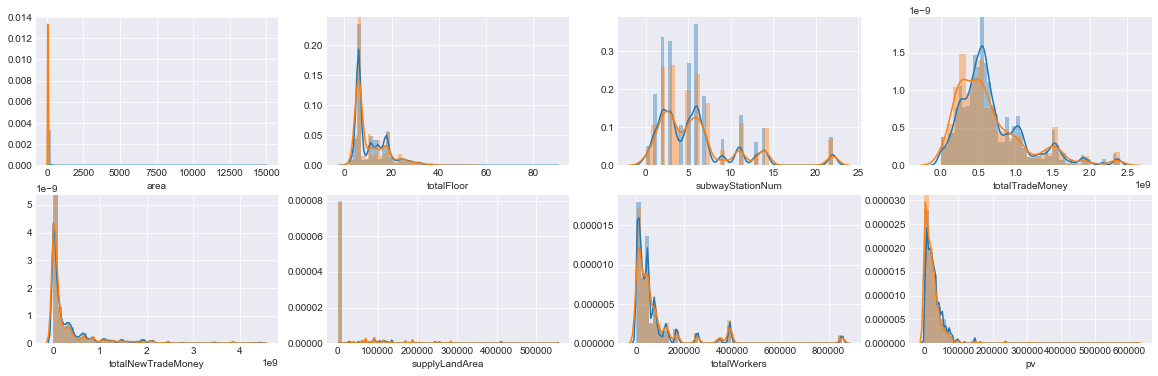

In [56]:
##########################异常值检验与处理
##########首先绘制训练集与验证集上数值型变量的直方图
fig,axes = plt.subplots(2,4,figsize=(20,6))
sns.distplot(house_train['area'],ax=axes[0][0])
sns.distplot(house_test['area'],ax=axes[0][0])
sns.distplot(house_train['totalFloor'],ax=axes[0][1])
sns.distplot(house_test['totalFloor'],ax=axes[0][1])
sns.distplot(house_train['subwayStationNum'],ax=axes[0][2])
sns.distplot(house_test['subwayStationNum'],ax=axes[0][2])
sns.distplot(house_train['totalTradeMoney'],ax=axes[0][3])
sns.distplot(house_test['totalTradeMoney'],ax=axes[0][3])
sns.distplot(house_train['totalNewTradeMoney'],ax=axes[1][0])
sns.distplot(house_test['totalNewTradeMoney'],ax=axes[1][0])
sns.distplot(house_train['supplyLandArea'],ax=axes[1][1])
sns.distplot(house_test['supplyLandArea'],ax=axes[1][1])
sns.distplot(house_train['totalWorkers'],ax=axes[1][2])
sns.distplot(house_test['totalWorkers'],ax=axes[1][2])
sns.distplot(house_train['pv'],ax=axes[1][3])
sns.distplot(house_test['pv'],ax=axes[1][3])
plt.show()

上面绘制了部分有代表性的数值型变量的直方图，从上图可以发现：房屋面积(area)变量在训练集和测试集的分布有较大差异，其余变量在两数据集之间的差距不大。下面看下area这个特征：

In [77]:
house_train['area'].describe(),house_test['area'].describe()

(count    41440.000000
 mean        70.959409
 std         88.119569
 min          1.000000
 25%         42.607500
 50%         65.000000
 75%         90.000000
 max      15055.000000
 Name: area, dtype: float64, count    2469.000000
 mean       76.031839
 std        29.080334
 min        15.000000
 25%        53.000000
 50%        73.160000
 75%        94.320000
 max       150.000000
 Name: area, dtype: float64)

上面结果显示，训练集与测试集房屋面积均值相差不大，但训练集房屋面积方差更大，数据波动性更大，并且数据有明显的异常值，用均方差法剔除异常值：

In [78]:
house_train = house_train.loc[(house_train['area'] > 15) & (house_train['area'] < house_train['area'].mean()+3*house_train['area'].std()),:]

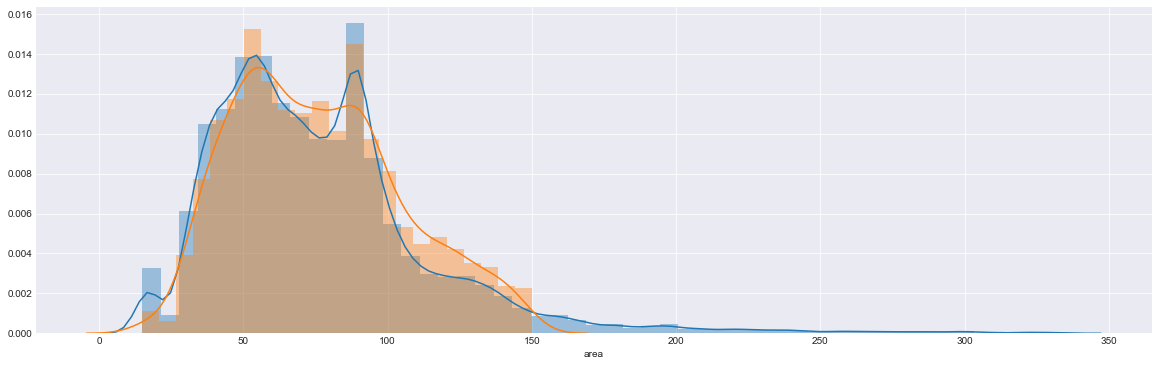

In [82]:
fig,axes = plt.subplots(1,1,figsize=(20,6))
sns.distplot(house_train['area'])
sns.distplot(house_test['area'])
plt.show()

In [ ]:
结果与未处理之前有很大改观，训练集测试集分布基本一致。